In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, metrics, model_selection 
import pandas as pd

In [3]:
df = pd.read_csv(DATOS_DIR + 'Iris.csv')

# Tomamos todas las columnas menos la última
X = np.array(df.iloc[:, 0:-1])
T = np.array(df.iloc[:,-1])

#Hay 50 muestras de cada tipo de flor
print(T[[1,50,100]])

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [4]:
# convertimos las etiquetas categóricas en numéricas
encoder = preprocessing.LabelEncoder()
T = encoder.fit_transform(T)
print(T[[1,50,100]])

[0 1 2]


In [5]:
#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, T_train, T_test = model_selection.train_test_split( \
        X, T, test_size=0.30) #, random_state=42)

T_trainB = to_categorical(T_train)
print(T_trainB[:5, :])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [6]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)

### Definición del modelo

In [7]:
# Crear un modelo de capas secuenciales
model=Sequential()

# Agregar las capas al modelo
model.add(Dense(2, input_shape=[4], activation='tanh'))    #linear, sigmoid, tanh, ReLU, LeakyReLU
model.add(Dense(3, activation='softmax'))

# Imprimir un resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Configuración para entrenamiento
#model.compile(optimizer=SGD(learning_rate=0.05), loss='mse', metrics='accuracy')
model.compile(optimizer=SGD(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import LambdaCallback

# Define el callback
def on_epoch_end(epoch, logs):
    if (epoch + 1) % 100 == 0:  # Cambia 100 por el número de épocas deseado
        print(f"Epoch {epoch + 1}: loss = {logs['loss']}, accuracy = {logs['accuracy']}")

# Crea el LambdaCallback
epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# Entrena el modelo con el callback
H = model.fit(X_train,T_trainB, epochs=1000, callbacks=[epoch_end_callback], verbose=0)

Epoch 100: loss = 0.2166157066822052, accuracy = 0.9333333373069763
Epoch 200: loss = 0.09940176457166672, accuracy = 0.9714285731315613
Epoch 300: loss = 0.07398077100515366, accuracy = 0.9809523820877075
Epoch 400: loss = 0.06332261115312576, accuracy = 0.9809523820877075
Epoch 500: loss = 0.05741148442029953, accuracy = 0.9809523820877075
Epoch 600: loss = 0.055620092898607254, accuracy = 0.9809523820877075
Epoch 700: loss = 0.05304247885942459, accuracy = 0.9809523820877075
Epoch 800: loss = 0.05067062750458717, accuracy = 0.9809523820877075
Epoch 900: loss = 0.05057942494750023, accuracy = 0.9809523820877075
Epoch 1000: loss = 0.05011608824133873, accuracy = 0.9809523820877075


In [10]:
# Calcular el error del modelo
score = model.evaluate(X_train, T_trainB) 
print('Error :', score[0]) 
print('Accuracy:', score[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.0486 - accuracy: 0.9810
Error : 0.04864926636219025
Accuracy: 0.9809523820877075


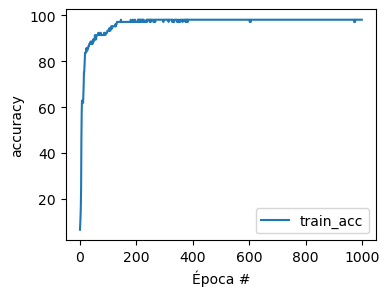

In [11]:
# dibuja accuracy del progreso del entrenamiento
accuracy = np.array(H.history["accuracy"])

N = np.arange(0, len(accuracy))
plt.figure(figsize=(4,3))
plt.plot(N, 100*accuracy, label="train_acc")
#plt.title("Efectividad de Entrenamiento")
plt.xlabel("Época #")
plt.ylabel("accuracy")
plt.legend(loc="lower right")

In [12]:
# predecir la salida del modelo
Y_pred = model.predict(X_train)
print(Y_pred[:5])

Y_pred2 = np.argmax(Y_pred,axis=1)
print(Y_pred2[:5])

print("%% aciertos X_train : %.3f" % metrics.accuracy_score(T_train, Y_pred2))

4/4 [==============================] - 0s 2ms/step
[[1.3864019e-04 5.9157545e-03 9.9394566e-01]
 [9.9431545e-01 5.6327367e-03 5.1836992e-05]
 [2.4436943e-03 9.9342680e-01 4.1295630e-03]
 [1.0239174e-04 3.9879959e-03 9.9590957e-01]
 [2.5802501e-03 9.9418950e-01 3.2302197e-03]]
[2 0 1 2 1]
% aciertos X_train : 0.981


In [13]:
report = metrics.classification_report(T_train, Y_pred2)
print("Confusion matrix Training:\n%s" % report) 

MM = metrics.confusion_matrix(T_train, Y_pred2)
print("Confusion matrix:\n%s" % MM)

Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.97      0.97      0.97        38
           2       0.97      0.97      0.97        37

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105

Confusion matrix:
[[30  0  0]
 [ 0 37  1]
 [ 0  1 36]]


In [14]:
model.save("miniIris.keras")

In [15]:
from keras.models import load_model
modelo2 = load_model("miniIris.keras")
modelo2.summary()

# predecir la salida del modelo
Y_pred = modelo2.predict(X_train)
print(Y_pred[:5])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 2ms/step
[[1.3864019e-04 5.9157545e-03 9.9394566e-01]
 [9.9431545e-01 5.6327367e-03 5.1836992e-05]
 [2.4436943e-03 9.9342680e-01 4.1295630e-03]
 [1.0239174e-04 3.9879959e-03 9.9590957e-01]
 [2.5802501e-03 9.9418950e-01 3.2302197e-03]]
